<center><font size="5"><b>Causal AI: <br> Causal Impact of Player Substitutions on Soccer Team Performance <br> Statsbomb Data Analysis</b></font></center>

In [1]:
import pathlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from causalai.simulation__ import simulate_matches
from causalai.auxiliaries import *


import dowhy
import networkx as nx
import pygraphviz
# import pgmpy

from pgmpy.models import DiscreteBayesianNetwork
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from pgmpy.inference import CausalInference

import arviz as az
import pymc as pm

In [2]:
plt.style.use("seaborn-v0_8")
sns.set_palette("husl")
seed = sum(map(ord, "eda-simulation"))
rng = np.random.default_rng(seed)

In [3]:
def R2(y,yhat,ybar):

    SSR = sum((y-yhat)**2)
    SST = sum((y-ybar)**2)
    return 1 - SSR/SST
    

In [4]:
# =================================== USER INTERACTION -- Global Parameters =================================== #

# -------------------------------- Data -------------------------------- #


# --- Path to the main directory: [None; str]
directory = '/Users/maximilian/Dropbox/Max/52_SoccerCausality' 


# -------------------------------- Model -------------------------------- #

# --- Select the outcomes (Y) that you want to analyze the causal drivers of: ['shots','goals','passes']
OUTCOMES = ["shots","goals","passes"]


# -------------------------------- Figures -------------------------------- #

# --- Want to save the figures? [True; False]
SAVE_FIG = False

# =================================== USER INTERACTION -- Global Parameters =================================== #

<br>

## 00. &emsp; Data Loading / Simulation

In [5]:
# =================================== 00.1 Load the Data =================================== #

# --- Read in the Data:
df = pd.read_csv(f'{directory}/10_data/data_StatsBomb__byMatch_bySub.csv').astype({'match_id':int})
    

# --- Number of Matches with Substitutions:
matchID__Sub = list(df.loc[df['substitution_replacementNumber__off'].dropna().index,:]['match_id'].unique())

print(f"\n# Match Situations:    {df.shape[0]}")
print(f"# Unique Matches:      {len(df['match_id'].unique())}")
print(f"# Matches with Sub:    {len(matchID__Sub)}")
print(f"Matches with Subs (%): {len(matchID__Sub) / len(df['match_id'].unique()) * 100:.2f}%")
print("\n")
df.head()


# Match Situations:    4950
# Unique Matches:      2327
# Matches with Sub:    2210
Matches with Subs (%): 94.97%




,match_status,match_id,competition,season,team_off,team_off__id,team_def,team_def__id,team_off__score60,team_def__score60,...,shots_target__def__pre,shots_target__def__post,goals_scored__off__pre,goals_scored__off__post,goals_scored__def__pre,goals_scored__def__post,substitution_tactical__off__pre,substitution_tactical__off__post,substitution_tactical__def__pre,substitution_tactical__def__post
0,3888704__59,3888704,International - FIFA World Cup,1958,France,771.0,Brazil,781.0,1.0,3.0,...,17.0,10.0,1.0,1.0,3.0,2.0,0.0,0.0,0.0,0.0
1,3888705__59,3888705,International - FIFA World Cup,1958,Sweden,790.0,Brazil,781.0,1.0,3.0,...,11.0,4.0,1.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0
2,3888854__59,3888854,International - FIFA World Cup,1962,Mexico,794.0,Brazil,781.0,0.0,1.0,...,13.0,6.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0
3,3888699__76,3888699,International - FIFA World Cup,1970,Czechoslovakia,17469.0,Brazil,781.0,1.0,2.0,...,14.0,2.0,1.0,0.0,3.0,1.0,1.0,0.0,1.0,0.0
4,3888700__62,3888700,International - FIFA World Cup,1970,England,768.0,Brazil,781.0,0.0,1.0,...,8.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [6]:
# =================================== 00.2 For Compatibility further down the Road =================================== #

# --- Score Differential in Minute 60:
df['score_diff'] = df['team_off__score60'] - df['team_def__score60']

# --- Indicator whether a substitution was made or not:
df['sub'] = np.where(df['match_id'].isin(matchID__Sub),1,0)


# --- Outcomes per Minute, pre- & post-event:
for team in ['off','def']:

    # --- Passes per Minute:
    df[f'passes_perMin__{team}__pre'] = df[f'passes_total__{team}__pre'] / df['substitution_minute__off']
    df[f'passes_perMin__{team}__post'] = df[f'passes_total__{team}__post'] / df['substitution_minuteDelta__off']
    
    # --- Shots per Minute:
    df[f'shots_perMin__{team}__pre'] = df[f'shots_total__{team}__pre'] / df['substitution_minute__off']
    df[f'shots_perMin__{team}__post'] = df[f'shots_total__{team}__post'] / df['substitution_minuteDelta__off']
    
    # --- Goals per Minute:
    df[f'goals_perMin__{team}__pre'] = df[f'goals_scored__{team}__pre'] / df['substitution_minute__off']
    df[f'goals_perMin__{team}__post'] = df[f'goals_scored__{team}__post'] / df['substitution_minuteDelta__off']


# --- Strength Differential Passes:
df['strength_diff__passes'] = df['passes_total__off__pre'] - df['passes_total__def__pre']

# --- Strength Differential Shots:
df['strength_diff__shots'] = df['shots_total__off__pre'] - df['shots_total__def__pre']

# --- Strength Differential Goals:
df['strength_diff__goals'] = df['goals_scored__off__pre'] - df['goals_scored__def__pre']


# --- Offense Passes per Minute - Differential:
df['passes_perMin__off__DIFF' ] = df['passes_perMin__off__post'] - df['passes_perMin__off__pre']

# --- Offense Shots on Target per Minute - Differential:
df['shots_perMin__off__DIFF' ] = df['shots_perMin__off__post'] - df['shots_perMin__off__pre']

# --- Offense Goals per Minute - Differential:
df['goals_perMin__off__DIFF' ] = df['goals_perMin__off__post'] - df['goals_perMin__off__pre']



/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_56102/293424576.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['score_diff'] = df['team_off__score60'] - df['team_def__score60']
/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_56102/293424576.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['sub'] = np.where(df['match_id'].isin(matchID__Sub),1,0)
/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_56102/293424576.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually 

In [7]:
# =================================== 00.3 Features that could influence Strength-Differential =================================== #


[c.split('__off__pre')[0] for c in df.columns if '__off__pre' in c]

['clearances_total',
 'dribble_total',
 'dribble_success',
 'duel_total',
 'duel_success',
 'fouls_committed',
 'interceptions_total',
 'interceptions_success',
 'pass_shot_assist',
 'pass_goal_assist',
 'pass_success_length__total',
 'pass_success_length__0_5',
 'pass_success_length__5_10',
 'pass_success_length__10_20',
 'pass_success_length__20_40',
 'pass_success_length__40',
 'passes_total',
 'passes_success',
 'shots_total',
 'shots_target',
 'goals_scored',
 'substitution_tactical',
 'passes_perMin',
 'shots_perMin',
 'goals_perMin']

In [8]:
# ==================================== Pre-& Post-Substitution Differentials ==================================== #

"""
    Instead of looking at 'totals', we now compute:
        
        (i)  success rates, and 
        (ii) build a composite index of team-strength, composed of the success rates of
             (ii.a) passes
             (ii.b) shots
             (ii.c) duels
             (ii.d) interceptions
             (ii.e) dribbles

    ... for pre- & post-event segments.
             
"""



# --------------------------------- USER INTERACTION --------------------------------- #

# --- Weighting of Performance Components: [numbers have to sum up to 1!]
wPerformance = {'passes':0.2,'shots':0.2,'duels':0.2,'interceptions':0.2,'dribbles':0.2}

# --------------------------------- USER INTERACTION --------------------------------- #




for sub in ['pre','post']:

    # --- Strength Diff Rate Passes:
    df[f'pass_success_Rate__off__{sub}'] = (df[f'pass_success_length__0_5__off__{sub}'] + df[f'pass_success_length__5_10__off__{sub}'] +
                                        df[f'pass_success_length__10_20__off__{sub}'] + df[f'pass_success_length__20_40__off__{sub}'] +
                                        df[f'pass_success_length__40__off__{sub}']) / df[f'pass_success_length__total__off__{sub}']
    df[f'pass_success_Rate__def__{sub}'] = (df[f'pass_success_length__0_5__def__{sub}'] + df[f'pass_success_length__5_10__def__{sub}'] +
                                        df[f'pass_success_length__10_20__def__{sub}'] + df[f'pass_success_length__20_40__def__{sub}'] +
                                        df[f'pass_success_length__40__def__{sub}']) / df[f'pass_success_length__total__def__{sub}']
    
    # --- Strength Diff Rate Shots:
    df[f'shots_target_Rate__off__{sub}'] = df[f'shots_target__off__{sub}'] / df[f'shots_total__off__{sub}']
    df[f'shots_target_Rate__def__{sub}'] = df[f'shots_target__def__{sub}'] / df[f'shots_total__def__{sub}']
    
    # --- Strength Diff Interceptions:
    df[f'interceptions_Rate__off__{sub}'] = df[f'interceptions_success__off__{sub}'] / df[f'interceptions_total__off__{sub}']
    df[f'interceptions_Rate__def__{sub}'] = df[f'interceptions_success__def__{sub}'] / df[f'interceptions_total__def__{sub}']
    
    # --- Strength Diff Duels:
    df[f'duel_Rate__off__{sub}'] = df[f'duel_success__off__{sub}'] / df[f'duel_total__off__{sub}']
    df[f'duel_Rate__def__{sub}'] = df[f'duel_success__def__{sub}'] / df[f'duel_total__def__{sub}']
    
    # --- Strength Diff Dribble:
    df[f'dribble_Rate__off__{sub}'] = df[f'dribble_success__off__{sub}'] / df[f'dribble_total__off__{sub}']
    df[f'dribble_Rate__def__{sub}'] = df[f'dribble_success__def__{sub}'] / df[f'dribble_total__def__{sub}']
    
    
    
    # --- Strength Diff:
    df[f'strength__off__{sub}'] = (wPerformance[f'passes'] * df[f'pass_success_Rate__off__{sub}'] + 
                                   wPerformance[f'shots'] * df[f'shots_target_Rate__off__{sub}'] + 
                                   wPerformance[f'duels'] * df[f'duel_Rate__off__{sub}'] + 
                                   wPerformance[f'interceptions'] * df[f'interceptions_Rate__off__{sub}'] + 
                                   wPerformance[f'dribbles'] * df[f'dribble_Rate__off__{sub}'])
    df[f'strength__def__{sub}'] = (wPerformance[f'passes'] * df[f'pass_success_Rate__def__{sub}'] + 
                                   wPerformance[f'shots'] * df[f'shots_target_Rate__def__{sub}'] + 
                                   wPerformance[f'duels'] * df[f'duel_Rate__def__{sub}'] + 
                                   wPerformance[f'interceptions'] * df[f'interceptions_Rate__def__{sub}'] + 
                                   wPerformance[f'dribbles'] * df[f'dribble_Rate__def__{sub}'])
    df[f'strength_diff__{sub}'] = df[f'strength__off__{sub}'] - df[f'strength__def__{sub}']






/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_56102/3804909145.py:33: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'pass_success_Rate__off__{sub}'] = (df[f'pass_success_length__0_5__off__{sub}'] + df[f'pass_success_length__5_10__off__{sub}'] +
/var/folders/wv/ptzsw2sx50dc4_j6b16q80sr0000gn/T/ipykernel_56102/3804909145.py:36: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'pass_success_Rate__def__{sub}'] = (df[f'pass_success_length__0_5__def__{sub}'] + df[f'pass_success_length__5_10__def__{sub}'] +
/var/folde

<br>

## 1. &emsp; Descriptive Statistics

In [9]:
# =================================== 1.1 Some Preliminary Summary Statistics =================================== #

df.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
match_id,4950.0,2980168.65,1554456.26,7298.00,3749349.00,3825627.50,3888699.75,4020005.00
team_off__id,4950.0,985.92,2096.45,1.00,176.00,229.00,919.00,29167.00
team_def__id,4950.0,829.58,1791.47,1.00,175.00,220.00,857.00,29167.00
team_off__score60,4950.0,0.23,0.47,0.00,0.00,0.00,0.00,3.00
team_def__score60,4950.0,1.79,0.95,1.00,1.00,2.00,2.00,9.00
...,...,...,...,...,...,...,...,...
dribble_Rate__off__post,3750.0,0.55,0.36,0.00,0.33,0.55,1.00,1.00
dribble_Rate__def__post,3885.0,0.58,0.36,0.00,0.33,0.60,1.00,1.00
strength__off__post,2082.0,0.54,0.13,0.20,0.45,0.54,0.63,0.83
strength__def__post,2267.0,0.54,0.13,0.20,0.45,0.55,0.63,0.86


In [10]:
# =================================== 1.2 Number of Games with Substitutions made =================================== #


# --- Number of Matches:
matchID = df['match_id'].unique().tolist()
# --- Number of Matches with Substitutions:
matchID__Sub = list(df.loc[df['substitution_replacementNumber__off'].dropna().index,:]['match_id'].unique())
# --- Number of Matches with no Substitution:
matchID__noSub = list(df.loc[df['substitution_replacementNumber__off'].isna(),:]['match_id'].unique())



print("\nTreatment Distribution:")
print(f"  No substitution: {len(matchID__noSub)} ({len(matchID__noSub) / len(matchID):.1%})")
print(f"  Substitution:    {len(matchID__Sub)} ({len(matchID__Sub) / len(matchID):.1%})")


Treatment Distribution:
  No substitution: 117 (5.0%)
  Substitution:    2210 (95.0%)


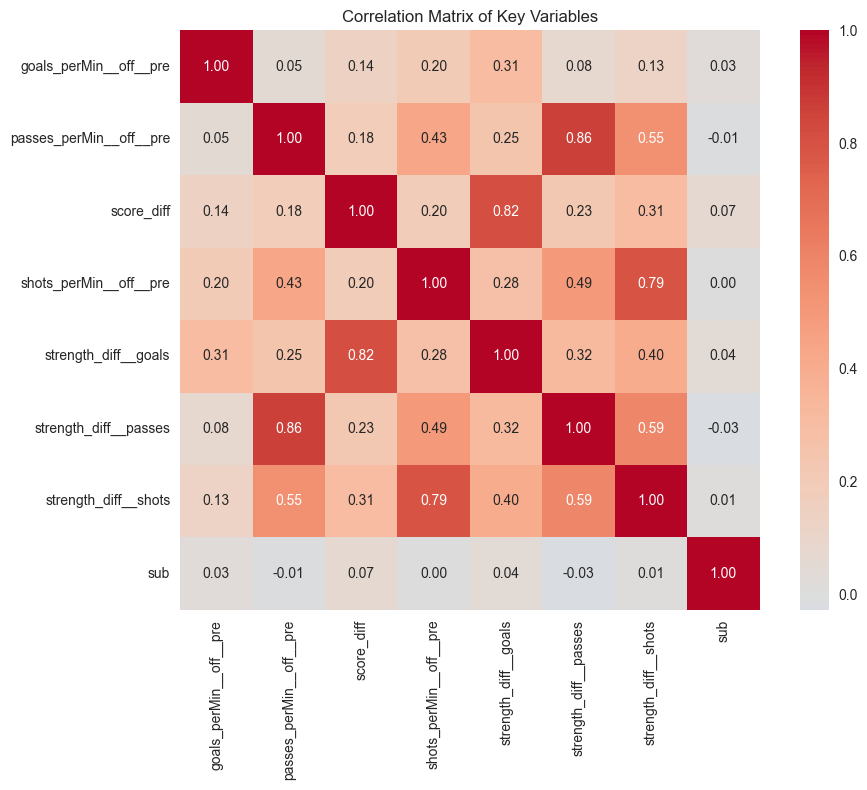

In [11]:
# =================================== 1.3 Inspect Correlations =================================== #


# --- Variables to inspect:
key_vars = list(np.unique(["sub","score_diff"] + [f'{o}_perMin__off__pre' for o in OUTCOMES] + [f'strength_diff__{o}' for o in OUTCOMES]))

# --- Correlation matrix of key variables:
correlation_matrix = df[key_vars].corr()

# --- Plot the Matrix:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, square=True, fmt=".2f")
plt.title("Correlation Matrix of Key Variables")
plt.tight_layout()
if SAVE_FIG:
    plt.savefig(OUTPUT_DIR / "correlation_matrix.png", dpi=300, bbox_inches="tight")
    print("\nCorrelation matrix saved to output directory.")
plt.show()



In [12]:
# ================================== 1.4 Zooming in on Score Differential ================================== #

print(f"\nCorrelation between Score Differential & Treatment Assignment: {df["score_diff"].corr(df["sub"]):.3f}")

print("\nCorrelation between Score Differential & Outcomes:\n")
for outcome in [f'{o}_perMin__off__DIFF' for o in OUTCOMES]:
    corr = df["score_diff"].corr(df[outcome])
    print(f"{outcome}: {corr:.3f}")


Correlation between Score Differential & Treatment Assignment: 0.071

Correlation between Score Differential & Outcomes:

shots_perMin__off__DIFF: -0.001
goals_perMin__off__DIFF: -0.001
passes_perMin__off__DIFF: -0.048


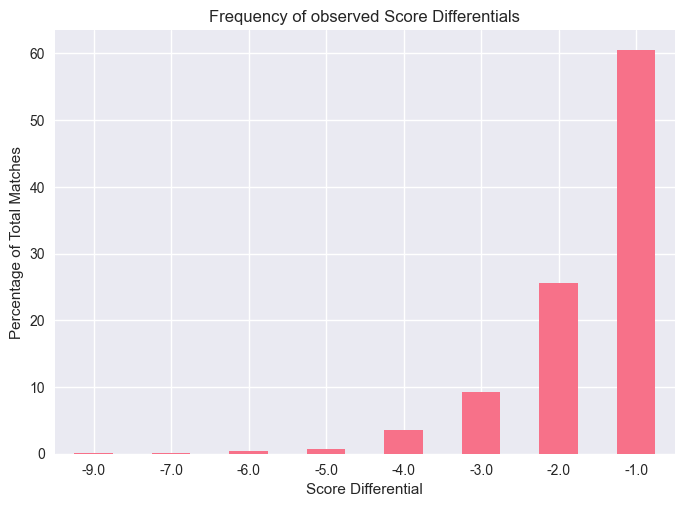

In [13]:
# ================================== 1.5 Distribution of Score Differentials ================================== #

# --- Count by Unique Match-ID:
df_plot = df.groupby(["score_diff",'match_id'])["sub"].sum().reset_index().copy()

(df_plot.groupby("score_diff")["sub"].count() / df_plot.shape[0] * 100).plot.bar(
    rot=0, ylabel="Percentage of Total Matches", title="Frequency of observed Score Differentials", xlabel="Score Differential"
);

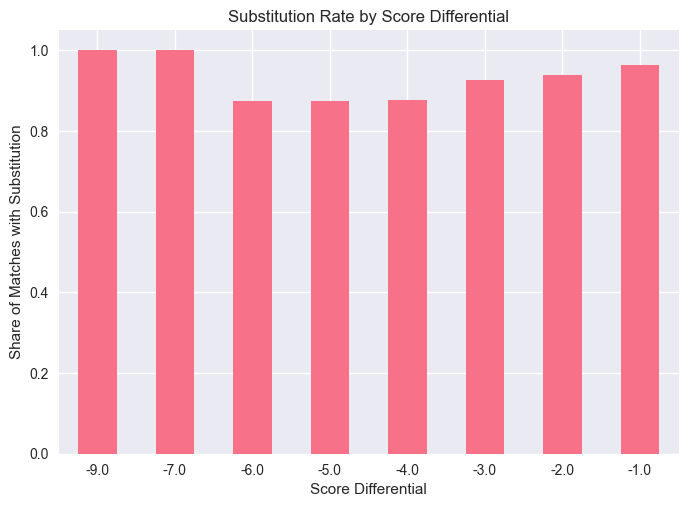

In [14]:
# ================================== 1.6 How does Substitution vary with Score Differential? ================================== #

# --- Count by Unique Match-ID:
df_plot = df.groupby(["score_diff",'match_id'])["sub"].sum().reset_index().copy()
df_plot['sub'] = np.where(df_plot['sub'] > 0 ,1,0)

(df_plot.groupby("score_diff")["sub"].sum() / df_plot.groupby("score_diff")["sub"].count()).plot.bar(
    rot=0, ylabel="Share of Matches with Substitution", title="Substitution Rate by Score Differential", xlabel="Score Differential"
);

<br>

## 2. &emsp; A Bayesian Model for Predicting the Impact

The model reads:

\begin{align}
    Y_i \; = \; \alpha \; + \; \beta_{sub} \, T_i + \mathbf{X}_i \, \mathbf{\gamma}^{'} \; + \; \varepsilon_i \quad ,
\end{align}

where $i$ denotes the *event* or *state* of a given match either at the time when a substitution by the lagging team was made, or -- in case the lagging team abstained from making a substitution after minute 60, despite being down by at least one goal -- the state in Minute 59.

$Y$ is the target, i.e. outcome variable. $T = \left\lbrace 0,1\right\rbrace$ is the *treatment variable*, i.e. a dummy that indicates whether the lagging team made a substitution or not.  

$\mathbf{X}$ is a vector of features containing `score_diff`, `strength__off__pre`,`strength__def__pre`. 

In **Section 2.1**, we set $Y$ to be the *difference* of the outcome variable between the its *post-* and *pre-* event value. That is, if $T=1$, it is the *difference* between the value *after* and *before* a substitution was made, respectively the *difference* of the outcome variable *after* and *before* the 60$^\text{th}$ minute, if $T=0$.

Instead, in **Section 2.2**, $Y$ is the observed value of the outcome variable in the *post-event* segment, and not the difference between the *post-* and *pre-event* segment. We thus include $Y_{off, \rightarrow i}$, i.e. the value of the outcome variable of the laggging team recorded up until event $i$, among the features $\mathbf{X}$.
E.g., if $Y$ is `passes_perMin__off__post` (the number of successfull passes per minute in the post-event segment), then $Y_{off, \rightarrow i}$ is the total number of passes made by the lagging team up until the minute of event $i$.

In [15]:
df.columns.tolist()

['match_status',
 'match_id',
 'competition',
 'season',
 'team_off',
 'team_off__id',
 'team_def',
 'team_def__id',
 'team_off__score60',
 'team_def__score60',
 'substitution_replacement__off',
 'substitution_replacementNumber__off',
 'substitution_minute__off',
 'substitution_minuteDelta__off',
 'clearances_total__off__pre',
 'clearances_total__off__post',
 'clearances_total__def__pre',
 'clearances_total__def__post',
 'dribble_total__off__pre',
 'dribble_total__off__post',
 'dribble_total__def__pre',
 'dribble_total__def__post',
 'dribble_success__off__pre',
 'dribble_success__off__post',
 'dribble_success__def__pre',
 'dribble_success__def__post',
 'duel_total__off__pre',
 'duel_total__off__post',
 'duel_total__def__pre',
 'duel_total__def__post',
 'duel_success__off__pre',
 'duel_success__off__post',
 'duel_success__def__pre',
 'duel_success__def__post',
 'fouls_committed__off__pre',
 'fouls_committed__off__post',
 'fouls_committed__def__pre',
 'fouls_committed__def__post',
 'inte

<br>

### 2.1 &emsp; $Y$: &ensp; Difference between post- & pre-Event Performance


Here, $Y$ is the *difference* of the outcome variable between the its *post-* and *pre-* event value. That is, if $T=1$, it is the *difference* between the value *after* and *before* a substitution was made, respectively the *difference* of the outcome variable *after* and *before* the 60$^\text{th}$ minute, if $T=0$.

In [46]:
# --------------------------------- USER INTERACTION --------------------------------- #

# --- Which is the outcome (Y) you are interested in to analyze? ['passes','shots','goals']
target = "passes"

# --- Transform the target? [None; 'log']
target_transform = 'log'

# --- Set the Features you want to include:
features = ['sub','score_diff','strength__off__pre','strength__def__pre']

# --------------------------------- USER INTERACTION --------------------------------- #


# --- Outcome Label:
outcome_label = f'{target}_perMin__off__DIFF' 

# --- Regression Matrix:
df_reg = df[features+[outcome_label]].dropna().copy()

# --- If log-Transformation was requested:
if target_transform == 'log':
    df_reg[outcome_label] = np.log(df_reg[outcome_label])



COORDS = {
    'obs_id': df_reg.index,
    'features': features,
}


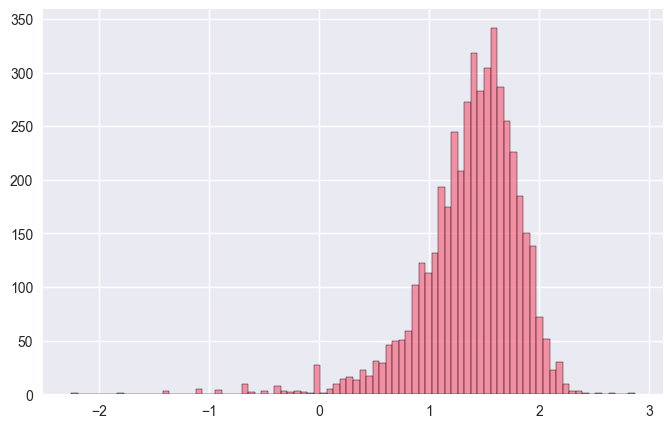


Mean:       1.38
SD:         0.45
Skew:      -1.51
Kurtosis:   8.27


In [47]:

# --- Get the Target:
s_plot = df_reg[outcome_label].copy()

fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=s_plot.values,ax=ax)
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.show()

# --- Some Summary Statistics:

print(f'\nMean:      {s_plot.mean(): .2f}')
print(f'SD:        {s_plot.std(): .2f}')
print(f'Skew:      {s_plot.skew(): .2f}')
print(f'Kurtosis:  {s_plot.kurt()+3: .2f}')


In [88]:

with pm.Model(coords=COORDS) as CausalSoccer_model:
    
    # ================================== Set the Data ================================== #
    X = pm.Data('X',df_reg[features].to_numpy(),dims=('obs_id','features'))
    Y = pm.Data('Y',df_reg[outcome_label].to_numpy(),dims='obs_id')
    

    # ================================== Set the priors ================================== #

    # -------------------------------- Alpha -------------------------------- # 
   
    # --- Hyperparameter: Standard-Deviation:
    sigma__alpha = pm.HalfNormal('sigma__alpha',sigma=3)
    #sigma__alpha = pm.Exponential('sigma__alpha',lam=1)
    

    # --- League-Specific
    alpha = pm.Normal('alpha', mu=df_reg[outcome_label].mean(), sigma=sigma__alpha)


    # -------------------------------- Betas -------------------------------- # 

    # --- Variation in the loadings:
    sigma_betas = pm.HalfNormal('sigma_betas',sigma=3,dims='features')
    #sigma_betas = pm.Exponential('sigma_betas',lam=0.5,dims='features')

    # --- Loadings: Pooled across all players & leagues
    betas = pm.Normal('betas',mu=0,sigma=sigma_betas,dims='features')


    # ---------------------- Prior for the Variance of the Student-T used to model the Target ------------------- # 
    # ---> set it a bit looser
    sigma_lik = pm.HalfNormal('sigma_lik',sigma=3)
    #sigma_lik = pm.Exponential('sigma_lik',lam=0.5)

    
    # ---------------------- Degrees of Freedom of Student-T used to model the Target ------------------- # 
    nu_lik = pm.HalfNormal('nu_lik',sigma=0.1)
    #nu_lik = pm.Exponential('nu_lik',lam=0.1)


    
    # ================================== Compute the Conditional Mean ================================== #
    dgp = pm.Deterministic('dgp', alpha + X @ betas, dims='obs_id')


    # ================================== Likelihood ================================== #

    likelihood = pm.StudentT('likelihood',
                             mu=dgp, 
                             sigma=sigma_lik, 
                             nu=nu_lik,
                             observed=Y, 
                             dims='obs_id')

    

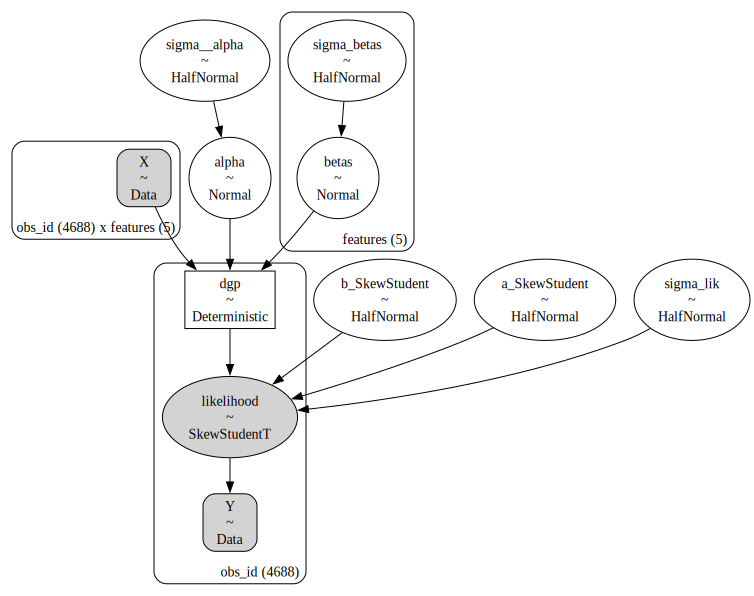

In [89]:
pm.model_to_graphviz(CausalSoccer_model)

In [90]:
with CausalSoccer_model:
    idata = pm.sample_prior_predictive(draws=5000)

INFO:pymc.sampling.forward:Sampling: [a_SkewStudent, alpha, b_SkewStudent, betas, likelihood, sigma__alpha, sigma_betas, sigma_lik]
/Users/maximilian/miniforge3/lib/python3.12/site-packages/scipy/stats/_continuous_distns.py:5714: RuntimeWarning: divide by zero encountered in divide
  return d2 / d3


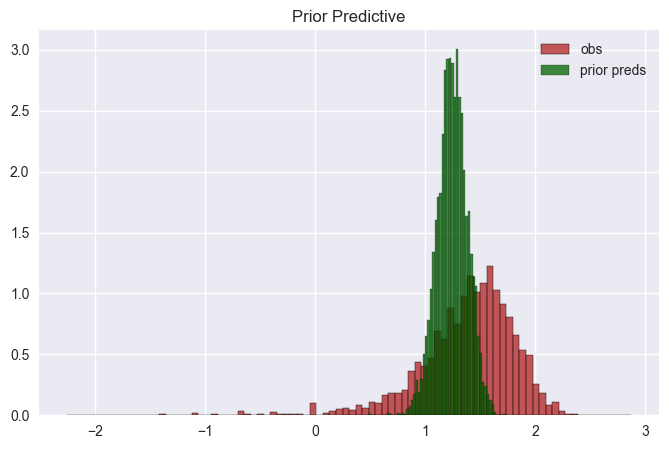


Mean:       1.25
SD:         0.14
Skew:      -0.17
Kurtosis:   3.29


In [91]:



fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=s_plot,color='firebrick',label='obs',ax=ax, stat='density')
sns.histplot(x=idata['prior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1),
             color='darkgreen',label='prior preds',ax=ax, stat='density')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.title('Prior Predictive')
plt.show()


# --- Some Summary Statistics:
s_priorPred = pd.Series(idata['prior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1))
print(f'\nMean:      {s_priorPred.mean(): .2f}')
print(f'SD:        {s_priorPred.std(): .2f}')
print(f'Skew:      {s_priorPred.skew(): .2f}')
print(f'Kurtosis:  {s_priorPred.kurt()+3: .2f}')


In [92]:
N_chains = 4

with CausalSoccer_model:
    idata = pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=N_chains,draws=1000)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 10 divergences after tuning. Increase `target_accept` or reparameterize.


In [97]:
# ===================================== Make Predictions ===================================== #

with CausalSoccer_model:
    idata.extend(pm.sample_posterior_predictive(idata))

INFO:pymc.sampling.forward:Sampling: [likelihood]


Output()

In [100]:
# ===================================== Evaluate the Fitting: Just a 'by-foot' workaround ===================================== #
if 1==2:
    # --- Extract the Estimates:
    alpha__samples = idata['posterior']['alpha'].stack(samples=('chain','draw')).to_numpy()
    beta__samples = idata['posterior']['betas'].stack(samples=('chain','draw')).to_numpy()
    
    
    # --- Predict:
    df_Yhat = pd.DataFrame(np.nan,index=df_reg.index,columns=[f'draw__{n}' for n in range(len(alpha__samples))])
    for n in tqdm(range(len(alpha__samples))):
        df_Yhat.loc[:,f'draw__{n}'] = alpha__samples[n] + df_reg[features] @ beta__samples[:,n]
    
    
    # --- Evaluate:
    print(f'\nGoodness of Fit (R^2): {R2(idata['constant_data']['Y'].to_numpy(),
                                         df_Yhat.median(axis=1).values,
                                         idata['constant_data']['Y'].mean().to_numpy()):.2f}')


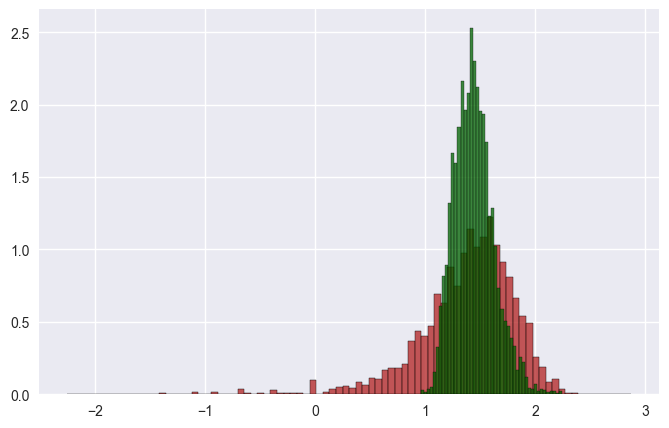


Mean:       1.44
SD:         0.18
Skew:       0.57
Kurtosis:   3.60


In [101]:
# ===================================== Plot the Posterior Predictive vs. the Target ===================================== #


# --- Get the Target:
s_plot = df_reg[outcome_label].copy()



fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=s_plot,color='firebrick',label='obs',ax=ax, stat='density')
sns.histplot(x=idata['posterior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1),
             color='darkgreen',label='preds',ax=ax, stat='density')
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.show()


s_postPred = pd.Series(idata['posterior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1))
print(f'\nMean:      {s_postPred.mean(): .2f}')
print(f'SD:        {s_postPred.std(): .2f}')
print(f'Skew:      {s_postPred.skew(): .2f}')
print(f'Kurtosis:  {s_postPred.kurt()+3: .2f}')



In [102]:
# ===================================== Evaluate the Fitting: the Quick Alternative ===================================== #


print(f'\nGoodness of Fit (R^2): {R2(s_plot,
                                     idata['posterior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1),
                                     s_plot.mean()):.2f}')


Goodness of Fit (R^2): 0.17


In [103]:
features

['sub',
 'score_diff',
 'strength__off__pre',
 'strength__def__pre',
 'passes_perMin__off__pre']

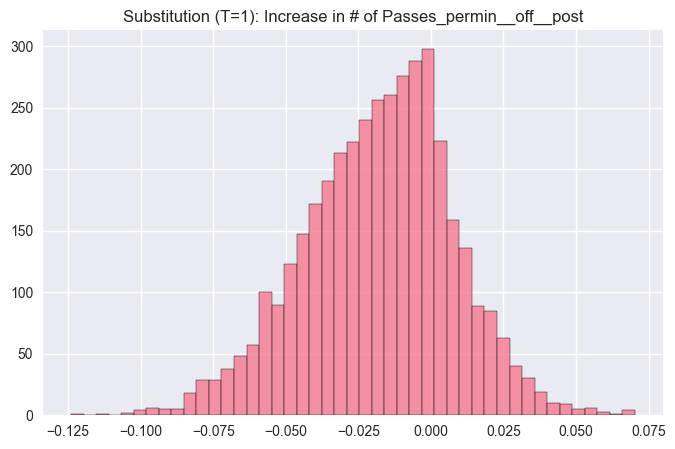



Lower Bound  2.5%:  -0.07
Mean:               -0.02
Upper Bound 97.5%:   0.03


In [104]:
# ===================================== Evaluate the Treatment Effect: Plot '\beta_{sub}' ===================================== #


# --------------------------- USER INTERACTION --------------------------- #

# --- Confidence Interval: ]0.5,1]
pick_q = 0.95

# --- Which feature?
pick_feature = 'sub'

# --------------------------- USER INTERACTION --------------------------- #


beta__samples = idata['posterior']['betas'][:,:,features.index(pick_feature)].to_numpy().flatten()



fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=beta__samples,ax=ax)
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.title(f'Substitution (T=1): Increase in # of {outcome_label.capitalize()}')
plt.show()

# --- Some Summary Statistics:


print('\n')
print(f'Lower Bound  {(1-pick_q)/2*100:.1f}%:  {np.quantile(beta__samples,q=(1-pick_q)/2): .2f}')
print(f'Mean:               {beta__samples.mean(): .2f}')
print(f'Upper Bound {(1-(1-pick_q)/2)*100:.1f}%:  {np.quantile(beta__samples,q=1-(1-pick_q)/2): .2f}')


<br>

### 2.2 &emsp; $Y$: &ensp; Post-Event Performance


$Y$ is the observed value of the outcome variable in the *post-event* segment, and not the difference between the *post-* and *pre-event* segment. We thus include $Y_{off, \rightarrow i}$, i.e. the value of the outcome variable of the laggging team recorded up until event $i$, among the features $\mathbf{X}$.


In [56]:
# --------------------------------- USER INTERACTION --------------------------------- #

# --- Which is the outcome (Y) you are interested in to analyze? ['passes','shots','goals']
target = "shots"

# --- Transform the target? [None; 'log']
target_transform = 'log'

# --- Set the Features you want to include:
features = ['sub','score_diff','strength__off__pre','strength__def__pre']

# --------------------------------- USER INTERACTION --------------------------------- #


# --- Outcome Label:
outcome_label = f'{target}_perMin__off__post'

# --- Add the pre-Event Equivalent to the Features:
features += [f'{target}_perMin__off__pre']

# --- Regression Matrix
df_reg = df[features+[outcome_label]].dropna().copy()
df_reg = df_reg[df_reg[outcome_label] != 0]

# --- If log-Transformation was requested
if target_transform == 'log':
    df_reg[outcome_label] = np.log(df_reg[outcome_label])



COORDS = {
    'obs_id': df_reg.index,
    'features': features,
}


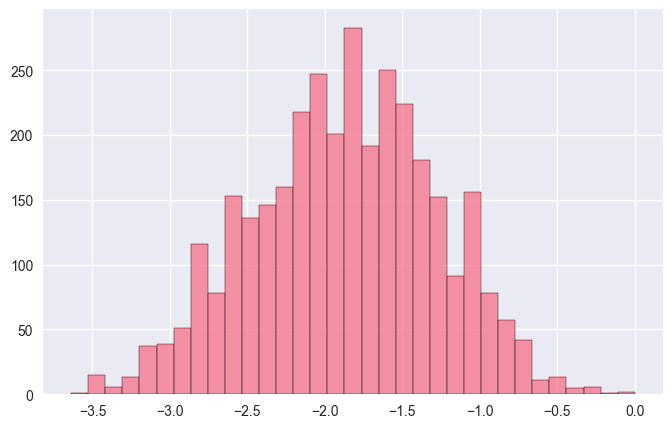


Mean:      -1.88
SD:         0.59
Skew:      -0.08
Kurtosis:   2.63


In [57]:

# --- Get the Target:
s_plot = df_reg[outcome_label].copy()

fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=s_plot.values,ax=ax)
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.show()

# --- Some Summary Statistics:

print(f'\nMean:      {s_plot.mean(): .2f}')
print(f'SD:        {s_plot.std(): .2f}')
print(f'Skew:      {s_plot.skew(): .2f}')
print(f'Kurtosis:  {s_plot.kurt()+3: .2f}')


In [115]:


with pm.Model(coords=COORDS) as CausalSoccer_model:


    # ================================== Set the Data ================================== #
    X = pm.Data('X',df_reg[features].to_numpy(),dims=('obs_id','features'))
    Y = pm.Data('Y',df_reg[outcome_label].to_numpy(),dims='obs_id')
    

    # ================================== Set the priors ================================== #

    # -------------------------------- Alpha -------------------------------- # 
   
    # --- Hyperparameter: Standard-Deviation:
    #sigma__alpha = pm.Exponential('sigma__alpha',lam=0.5)
    sigma__alpha = pm.HalfNormal('sigma__alpha',sigma=3)
    #mu__alpha = pm.Normal('mu__alpha',mu=0,sigma=2)
    mu__alpha = s_plot.mean()
    

    # --- League-Specific
    alpha = pm.Normal('alpha', mu=mu__alpha, sigma=sigma__alpha)


    # -------------------------------- Betas -------------------------------- # 

    # --- Variation in the loadings:
    sigma_betas = pm.HalfNormal('sigma_betas',sigma=3,dims='features')
    #sigma_betas = pm.Exponential('sigma_betas',lam=0.5,dims='features')

    # --- Loadings: Pooled across all players & leagues
    betas = pm.Normal('betas',mu=0,sigma=sigma_betas,dims='features')


    # ---------------------- Prior for the Variance of the Target ------------------- # 
    # ---> set it a bit looser
    sigma_lik = pm.HalfNormal('sigma_lik',sigma=5)
    #sigma_lik = pm.Exponential('sigma_lik',lam=0.1)


    
    # ================================== Compute the Conditional Mean ================================== #
    
    dgp = pm.Deterministic('dgp', alpha + X @ betas, dims='obs_id')

    

    # ================================== Likelihood ================================== #

    if not target_transform:

        
        likelihood = pm.LogNormal('likelihood',
                                   mu=dgp, 
                                   sigma=sigma_lik, 
                                   observed=Y, 
                                   dims='obs_id')
            
    elif target_transform == 'log':

        
        if target == 'passes':

            # ---------------------- Prior for the Parameters describing the Kurtosis of the Skewed-Student-T ------------------- # 
            a_SkewStudent = pm.HalfNormal('a_SkewStudent',sigma=3)
            b_SkewStudent = pm.HalfNormal('b_SkewStudent',sigma=3)
            #a_SkewStudent = pm.Exponential('a_SkewStudent',lam=0.1)
            #b_SkewStudent = pm.Exponential('b_SkewStudent',lam=0.1)

            
            
            likelihood = pm.SkewStudentT('likelihood',
                                        mu=dgp, 
                                        a=a_SkewStudent,
                                        b=b_SkewStudent,
                                        sigma=sigma_lik,
                                        observed=Y, 
                                        dims='obs_id')

        elif target == 'shots':
        
            likelihood = pm.Normal('likelihood',
                                    mu=dgp, 
                                    sigma=sigma_lik, 
                                    #sigma=2, 
                                    observed=Y, 
                                    dims='obs_id')


    


    

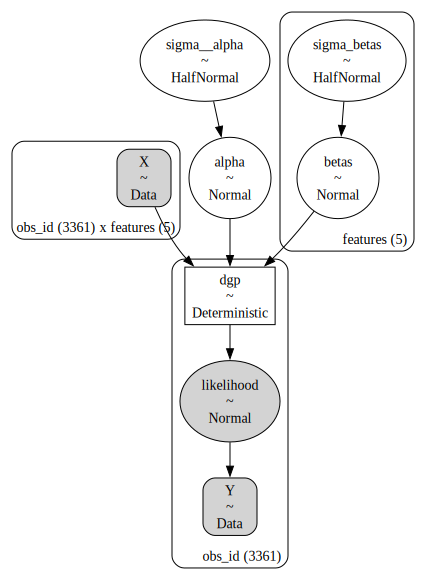

In [116]:
pm.model_to_graphviz(CausalSoccer_model)

In [117]:
with CausalSoccer_model:
    idata = pm.sample_prior_predictive(draws=5000)

INFO:pymc.sampling.forward:Sampling: [alpha, betas, likelihood, sigma__alpha, sigma_betas]


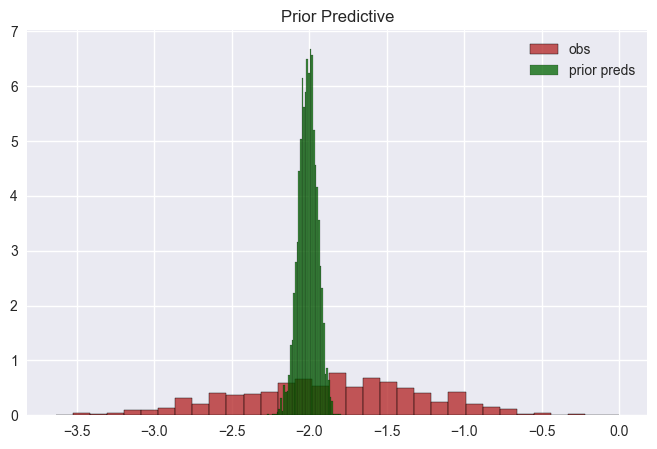


Mean:      -2.01
SD:         0.06
Skew:      -0.14
Kurtosis:   3.16


In [118]:



fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=s_plot,color='firebrick',label='obs',ax=ax, stat='density')
sns.histplot(x=idata['prior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1),
             color='darkgreen',label='prior preds',ax=ax, stat='density')
plt.ylabel('')
plt.xlabel('')
plt.legend()
plt.title('Prior Predictive')
plt.show()


# --- Some Summary Statistics:
s_priorPred = pd.Series(idata['prior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1))
print(f'\nMean:      {s_priorPred.mean(): .2f}')
print(f'SD:        {s_priorPred.std(): .2f}')
print(f'Skew:      {s_priorPred.skew(): .2f}')
print(f'Kurtosis:  {s_priorPred.kurt()+3: .2f}')


In [119]:
N_chains = 4

with CausalSoccer_model:
    idata = pm.sample(nuts_sampler="numpyro", target_accept=0.99, chains=N_chains,draws=1000)
    #idata = pm.sample(nuts_sampler="pymc", target_accept=0.99, chains=N_chains,draws=1000)


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

ERROR:pymc.stats.convergence:There were 33 divergences after tuning. Increase `target_accept` or reparameterize.


In [120]:
# ===================================== Make Predictions ===================================== #

with CausalSoccer_model:
    idata.extend(pm.sample_posterior_predictive(idata))

INFO:pymc.sampling.forward:Sampling: [likelihood]


Output()

In [121]:
# ===================================== Evaluate the Fitting: Just a 'by-foot' workaround ===================================== #
if 1==2:
    # --- Extract the Estimates:
    alpha__samples = idata['posterior']['alpha'].stack(samples=('chain','draw')).to_numpy()
    beta__samples = idata['posterior']['betas'].stack(samples=('chain','draw')).to_numpy()
    
    
    # --- Predict:
    df_Yhat = pd.DataFrame(np.nan,index=df_reg.index,columns=[f'draw__{n}' for n in range(len(alpha__samples))])
    for n in tqdm(range(len(alpha__samples))):
        df_Yhat.loc[:,f'draw__{n}'] = alpha__samples[n] + df_reg[features] @ beta__samples[:,n]
    
    
    # --- Evaluate:
    print(f'\nGoodness of Fit (R^2): {R2(idata['constant_data']['Y'].to_numpy(),
                                         df_Yhat.median(axis=1).values,
                                         idata['constant_data']['Y'].mean().to_numpy()):.2f}')


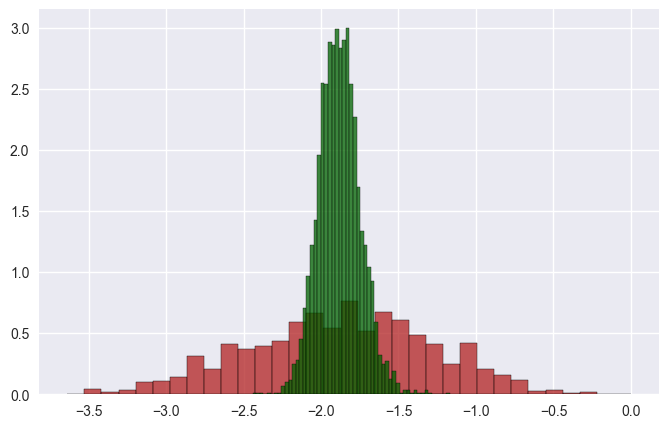


Mean:      -1.88
SD:         0.14
Skew:       0.28
Kurtosis:   3.80


In [122]:
# ===================================== Plot the Posterior Predictive vs. the Target ===================================== #


# --- Get the Target:
s_plot = df_reg[outcome_label].copy()



fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=s_plot,color='firebrick',label='obs',ax=ax, stat='density')
sns.histplot(x=idata['posterior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1),
             color='darkgreen',label='preds',ax=ax, stat='density')
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.show()


s_postPred = pd.Series(idata['posterior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1))
print(f'\nMean:      {s_postPred.mean(): .2f}')
print(f'SD:        {s_postPred.std(): .2f}')
print(f'Skew:      {s_postPred.skew(): .2f}')
print(f'Kurtosis:  {s_postPred.kurt()+3: .2f}')



In [123]:
# ===================================== Evaluate the Fitting: the Quick Alternative ===================================== #


print(f'\nGoodness of Fit (R^2): {R2(s_plot,
                                     idata['posterior_predictive']['likelihood'].stack(samples=('chain','draw')).median(axis=1),
                                     s_plot.mean()):.2f}')


Goodness of Fit (R^2): 0.05


In [41]:
features

['sub',
 'score_diff',
 'strength__off__pre',
 'strength__def__pre',
 'passes_perMin__off__pre']

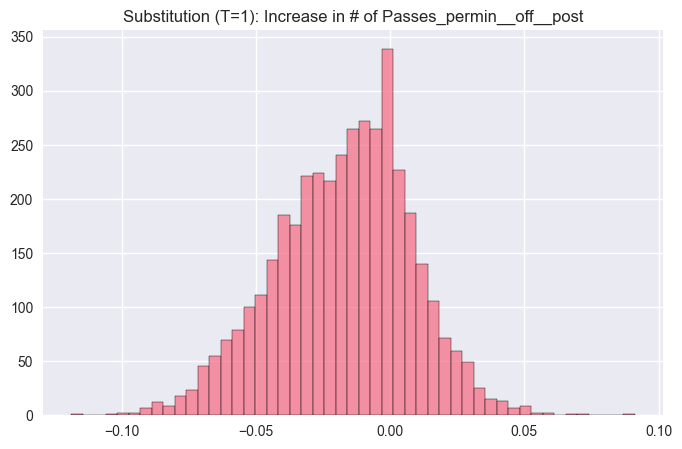



Lower Bound  2.5%:  -0.07
Mean:               -0.02
Upper Bound 97.5%:   0.03


In [42]:
# ===================================== Evaluate the Treatment Effect: Plot '\beta_{sub}' ===================================== #


# --------------------------- USER INTERACTION --------------------------- #

# --- Confidence Interval: ]0.5,1]
pick_q = 0.95

# --- Which feature?
pick_feature = 'sub'

# --------------------------- USER INTERACTION --------------------------- #


beta__samples = idata['posterior']['betas'][:,:,features.index(pick_feature)].to_numpy().flatten()



fig,ax=plt.subplots(figsize=(8,5))
sns.histplot(x=beta__samples,ax=ax)
plt.ylabel('')
plt.xlabel('')
plt.legend('')
plt.title(f'Substitution (T=1): Increase in # of {outcome_label.capitalize()}')
plt.show()

# --- Some Summary Statistics:


print('\n')
print(f'Lower Bound  {(1-pick_q)/2*100:.1f}%:  {np.quantile(beta__samples,q=(1-pick_q)/2): .2f}')
print(f'Mean:               {beta__samples.mean(): .2f}')
print(f'Upper Bound {(1-(1-pick_q)/2)*100:.1f}%:  {np.quantile(beta__samples,q=1-(1-pick_q)/2): .2f}')
